<a href="https://colab.research.google.com/github/johnsocf/CSCI_3202_HW_5/blob/master/hw5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
import os, sys
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import math
import cv2 as cv
import matplotlib.patches as patches
import statistics
import json

#sci kit learn packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

# keras packages
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers.experimental.preprocessing import CenterCrop

# additional packages
from google.colab import files
from time import time
from PIL import Image


In [4]:
!pip install kaggle
!pip install --upgrade kaggle

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.9)


In [5]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 8.5MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.9-cp36-none-any.whl size=73265 sha256=78cdf95e752ac595ae1fe8b29243e7896471c81ee738576c31d2b89df3ef82e7
  Stored in directory: /root/.cache/pip/wheels/68/6d/9b/7a98271454edcba3b56328cbc78c037286e787d004c8afee71
Successfully built kaggle
  Found existing installation: kaggle 1.5.9
    Uninstalling kaggle-1.5.9:
      Successfully uninstalled kaggle-1.5.9


In [6]:
!mkdir .kaggle

In [7]:
!mkdir .kaggle
!ls -a

mkdir: cannot create directory ‘.kaggle’: File exists
.  ..  .config	drive  .kaggle	sample_data


In [8]:
token = {"username":"catnippsunn","key":"d10a25e54993332212ca4e9f6a8dece2"}


In [21]:
!mkdir .kaggle
!ls -a

mkdir: cannot create directory ‘.kaggle’: File exists
.  ..  .config	drive  .kaggle	sample_data  test_resized  train_resized


In [22]:
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [23]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [24]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [25]:
!chmod 600 /root/.kaggle/kaggle.json

In [26]:
# root_path = 'drive/My Drive/kaggle_dataset/'

In [27]:
!kaggle competitions download -c histopathologic-cancer-detection -p /content

#List datasets and competitions
!kaggle datasets list   
!kaggle competitions list

#Search for datasets and competitions by name
!kaggle datasets list -s cancer
!kaggle competitions list -s histopathologic-cancer-detection


100% 6.31G/6.31G [03:14<00:00, 52.5MB/s]
100% 6.31G/6.31G [03:14<00:00, 34.7MB/s]
ref                                                     title                                         size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
unanimad/us-election-2020                               US Election 2020                             429KB  2020-11-14 13:00:04           3740        164  1.0              
manchunhui/us-election-2020-tweets                      US Election 2020 Tweets                      353MB  2020-11-09 18:51:59           2145        140  1.0              
antgoldbloom/covid19-data-from-john-hopkins-university  COVID-19 data from John Hopkins University     2MB  2020-11-14 06:04:01           1085         59  0.9705882        
headsortails/us-election-2020-presidential-debates   

In [28]:
!unzip \*.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  
  inflating: train/fa2f1d5e86165f63c57acdf9d23521f2b8070e0c.tif  
  inflating: train/fa2ffa

In [29]:
# set useful paths to image and label directories for succinct use in the notebook
model_path='.'
path='/content/'
train_folder='{}train'.format(path)
test_folder='{}test'.format(path)
train_folder_cr='{}train_cropped'.format(path)
test_folder_cr='{}test_cropped'.format(path)
train_label='{}train_labels.csv'.format(path)

In [30]:
# set up variables based on defaults for data directory sand shape paths
# this allows for easy configuration in the model building fitting.
# they will be overridden if the image crop code section is run.
directory_for_training = train_folder
directory_for_testing = test_folder
data_shape = (96, 96, 3)
dims = (data_shape[0], data_shape[1])

In [31]:
# add new directories in which to store cropped images.
!mkdir train_cropped
!mkdir test_cropped

In [32]:
# cropping images to middle 32 x 32 section where tumor would lie. (from known (96,96) height/width.)
# this test case involved setting image sizes to 32 x 32 instead of 96 x 96 in the keras model
# and updating the directory to use the test _res directories.

start_width, start_height = (96, 96)
new_width, new_height = (32, 32)
left_coord = start_width/4
top_coord = start_height/4
right_coord = 3 * start_width/4
bottom_coord = 3 * start_height/4

# crop function, iterates through each item in the directory.
# uses python image module PIL.  ref: https://pillow.readthedocs.io/en/stable/reference/Image.html
# crops each image and saves it in a directory
def crop_images(dirs, start_path, dest_path):
    for item in dirs:
        # if os.path.isfile(start_path+ '/' + item):
        im = Image.open(start_path+'/' + item)
        # splits text into root path and file extension (f and e)
        # f, e = os.path.splitext(start_path+'/' + item)
        # f_1, e_1 = os.path.splitext(dest_path+'/' + item)
        imCrop = im.crop((left_coord, top_coord, right_coord, bottom_coord))
        #imResize = imCrop.resize((96, 96))
        imCrop.save(dest_path + '/' + item)

# get directory path for test images
dirs_test = os.listdir(test_folder)
# 
crop_images(dirs_test, test_folder, test_folder_res)
# repeat for training images.
dirs_train = os.listdir(train_folder)
crop_images(dirs_train, train_folder, train_folder_res)

# reset configs used in model training and fit.
directory_for_training = train_folder_cr
directory_for_testing = test_folder_cr
data_shape = (32, 32)
dims = (data_shape[0], data_shape[1])

##**Set up Data Vis functionality.**

#code for displaying Data Vis:

1.  Histogram is defined for data investigation.

2.  Sample images are pulled out to display visual differences in images positive for cancerous tumor and those negative for a cancerous tumor.  This may give further idea of the visual distinction between classes.  The insight can be used to better understand correlation between feature size and CNN model architecture.
Label data has an image number associated with positive (1) and negative (0) samples.  The ID associated with the sample in each label data item will map to an image in the train folders.  This image can be read and stored for printing to the screen.

3.  Using the RGB channel, determine the mean colors and most seen colors per image.  Plot these out.  This may show a consistency in the colors found in the data in positive and negative samples, and should be considered relevant to overfitting in analysis.  Since training on RGB color scale could be a feature that could skew the results and be unreplicatable in potential future samples used with the model to determine predictions.  (i.e. purple tinged samples may be more representative of positive samples, while pink may be representative of negative samples in the data).

1.  Histogram Display Code.

In [41]:
# store function for data vis distribution histogram, used below.
def define_histogram(data, range, title, x_axis_label, y_axis_label, ax, graphType=""):
    colors = ['r', 'g', 'b']
    if range:
        counts, bins, p = ax.hist(data, range = range, bins=2, label="yellow", edgecolor='white', linewidth=1)
        p[0].set_facecolor('b')
        p[1].set_facecolor('y')
        ax.set_xticks(bins)
        ax.annotate('Negative', xy=(.5, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -18), textcoords='offset points', va='top', ha='center')
        ax.annotate('Positive', xy=(1.5, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -18), textcoords='offset points', va='top', ha='center')
    else:
        counts, bins, path = ax.hist(data, range=(0, 255), label="yellow", bins=4, edgecolor='white', linewidth=2)
        for idx, x in enumerate(path):
            for y in x:
                y.set_facecolor(colors[idx])
        ax.legend((path[0], path[1], path[2]),("R","G","B"))
        
        ax.set_xticks(bins)
        ax.title.set_text(graphType)
        ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
    
    plt.title(title, fontsize=16)
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    

2.  Sample image procurement code.

In [35]:
# loc gets rows from a pandas df given a certain set of conditions.
positive_image_samples = label_data_df.loc[label_data_df['label'] == 1].sample(6)
negative_image_samples = label_data_df.loc[label_data_df['label'] == 0].sample(6)
positive_image_sample_array = []
negative_image_sample_array = []
for sample in positive_image_samples['id']:
    path = os.path.join(train_folder, sample+'.tif')
    # cv2 open cv is a library for computer vision which provides an api for
    # reading an image file into an 2D array.
    img = cv.imread(path)
    # RAM space allow for storing a few images
    positive_image_sample_array.append(img)
        
# repeat for negative samples
for sample in negative_image_samples['id']:
    path = os.path.join(train_folder, sample+'.tif')
    img = cv.imread(path)
    negative_image_sample_array.append(img)

3.  Image display code for sample images.

In [50]:
def show_image_samples(images, title, axis, r):
  for i,img in enumerate(images, 0):
    axis[r,i].imshow(img)
    rect = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='g',facecolor='none', linestyle=':', capstyle='round')
    axis[r,i].add_patch(rect)
  axis[r,0].set_ylabel(title, size='large')

4.  Average and Prominent Color Depictions.
The code credit reference for this snippet which was adapted for the specifics of this purpose is from:
https://stackoverflow.com/questions/43111029/how-to-find-the-average-colour-of-an-image-in-python-with-opencv.  
Explanations of the code are included.

In [55]:
avg_colors_pos = []
avg_colors_neg = []


def show_colors(color_image, img_type, plot_title):
    average = color_image.mean(axis=0).mean(axis=0) # get the mean of each chromatic channel
    pixels = np.float32(color_image.reshape(-1, 3))

    n_colors = 5
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv.KMEANS_RANDOM_CENTERS

    _, labels, palette = cv.kmeans(pixels, n_colors, None, criteria, 10, flags)
    _, counts = np.unique(labels, return_counts=True)
    dominant = palette[np.argmax(counts)]
    
    avg_patch = np.ones(shape=color_image.shape, dtype=np.uint8)*np.uint8(average)
    if img_type == 'pos':
        avg_colors_pos.append(average)
    else:
        avg_colors_neg.append(average)

    indices = np.argsort(counts)[::-1]   
    freqs = np.cumsum(np.hstack([[0], counts[indices]/float(counts.sum())]))
    rows = np.int_(color_image[0].shape[0]*freqs)

    dom_patch = np.zeros(shape=color_image.shape, dtype=np.uint8)
    for i in range(len(rows) - 1):
        dom_patch[rows[i]:rows[i + 1], :, :] += np.uint8(palette[indices[i]])

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,6))
    if plot_title:
      fig.suptitle(plot_title,fontsize=20)
    ax0.imshow(avg_patch)
    ax0.set_title('Average color')
    ax0.axis('off')
    ax1.imshow(dom_patch)
    ax1.set_title('Dominant colors')
    ax1.axis('off')
    plt.show(fig)
    
def show_image_colors(data, title, ax):
    ax.imshow(data)
    ax.set_title(title)
    ax.axis('off')

# Data Exploration

Investigate data distribution of positive and negative samples within data.  It is evident that out of over 220K samples, about 60% of the samples are negative and 40% are positive.  The lack of consistent samples in each binary category may leave the CNN susceptable for overfitting, so additional measures to prevent this will be addressed in data preprocessing.

In [42]:
label_data_df = pd.read_csv(train_label)
print(label_data_df['label'].value_counts(normalize=True))
print(label_data_df.head())
label_data_df.describe()
print('')
print('Number of training images : ', len(label_data_df))
pos = round(sum(label_data_df['label'].values)/len(label_data_df), 2) * 100
neg = round((100 - pos), 2)
print('Ratio of positive to negative samples: ', "%d:%d" % (pos, neg))
test_img = plt.imread("/content/train/"+label_data_df.iloc[0]['id']+'.tif')
print('Images shape (M, N, d) where d = RGB value channels', test_img.shape)

0    0.594969
1    0.405031
Name: label, dtype: float64
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

Number of training images :  220025
Ratio of positive to negative samples:  41:59
Images shape (M, N, d) where d = RGB value channels (96, 96, 3)


# Data Vis

# Histogram Distribution

A data vis using matplot library to show a histogram of the positive and negative sample ration within the dataset depicts in further detail the binary ratio of samples mentioned from the descriptive data set stats previously.  This visually depicts the skew'd ratio tending towards more negative samples in the dataset, which could lead towards false negatives.

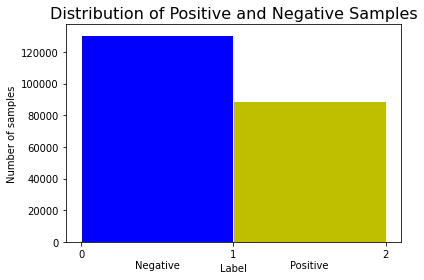

In [43]:
# utilize binary histogram function above.
fig, ax = plt.subplots()    
define_histogram(label_data_df.label, (0, 2), 'Distribution of Positive and Negative Samples', 'Label', 'Number of samples', ax)
plt.show()

## Image Samples

The following plots show the visual difference in positive and negative image samples, looking at the original 96 x 96 image as well as a center cropped version which isolates the patch where the cancerous tumor can be found that defines an image positive for the presence of cancer.  These depictions show just how feasible it is to determine this cancer given a naked eye.  The cancerous cell can be as small as 1px evident.  The model will be trained on both cropped and uncropped images to deduce if having more of the presence of outerlying cell data will add features to the CNN that become important.  If the cropped version is more accurate it will be deducable that training on the immediately relevant data is of value in fitting a model.

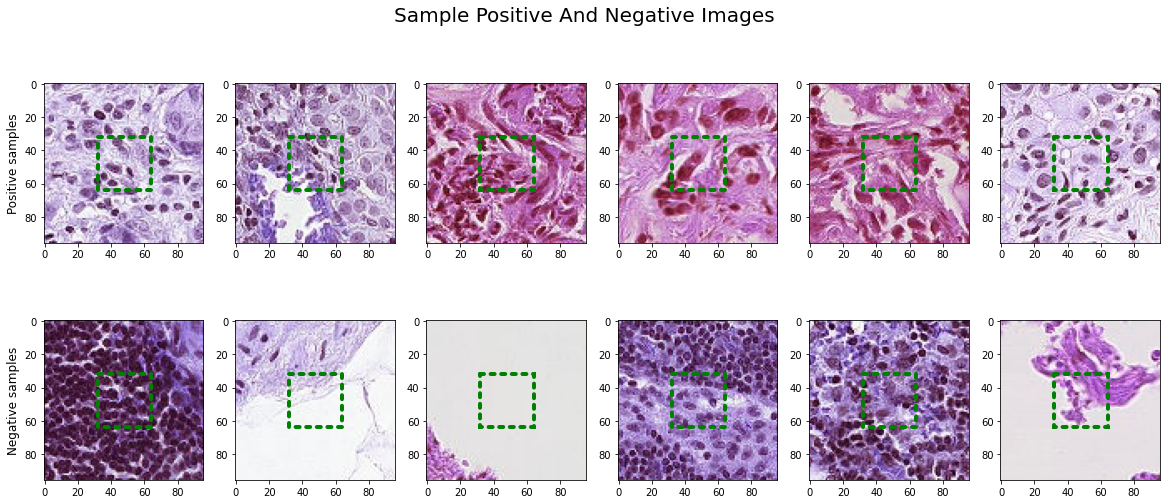

In [52]:
fig, ax0 = plt.subplots(2,6,figsize=(20,8))
fig.suptitle('Sample Positive And Negative Images',fontsize=20)
show_image_samples(positive_image_sample_array, 'Positive samples', ax0, 0)
show_image_samples(negative_image_sample_array, 'Negative samples', ax0, 1)

# Cropped Image Samples

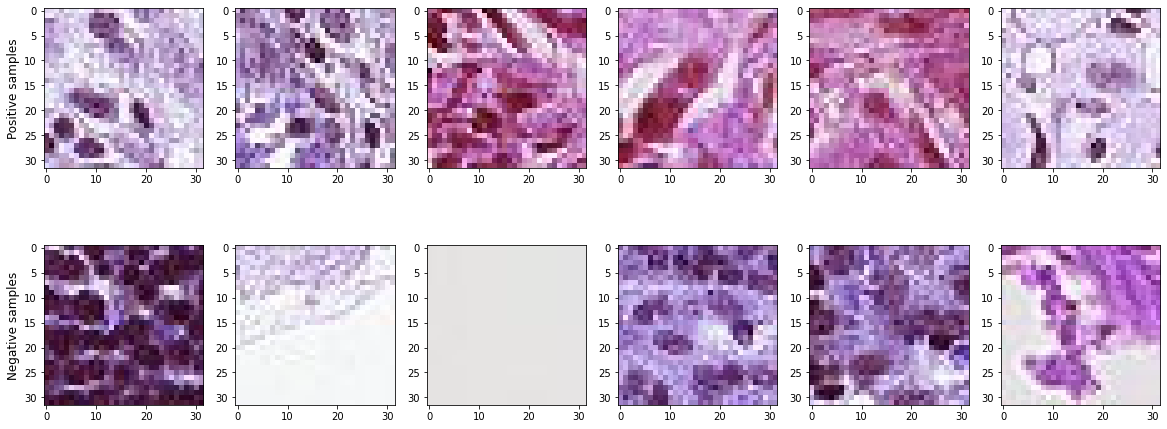

In [53]:
cropper = CenterCrop(height=32, width=32)
fig.suptitle('Sample 32 x 32 Center Cropped Positive And Negative Images',fontsize=20)
output_data_pos = cropper(positive_image_sample_array)
output_data_neg = cropper(negative_image_sample_array)
fig, ax0 = plt.subplots(2,6,figsize=(20,8))
show_image_samples(output_data_pos, 'Positive samples', ax0, 0)
show_image_samples(output_data_neg, 'Negative samples', ax0, 1)

# Color Trends in Image Samples
Displaying Average and Dominent Colors in Positive and Negative Samples.  There are immediately evident consistencies but not direct parallels within each binary classification group.  This visualization assumes the image subsamples are representative of the whole since they have been selected randomly.  The image subsamples are consistent with those depicted in the sample images, above.

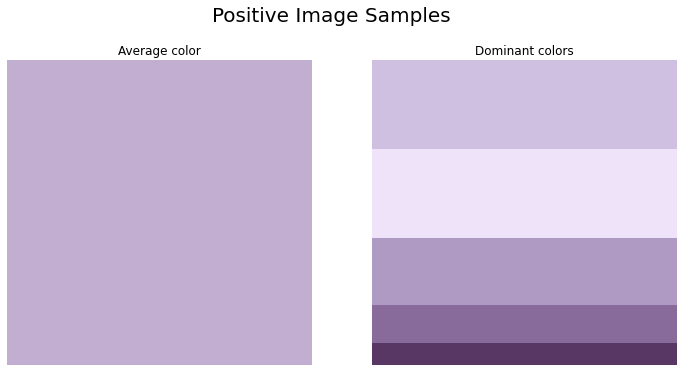

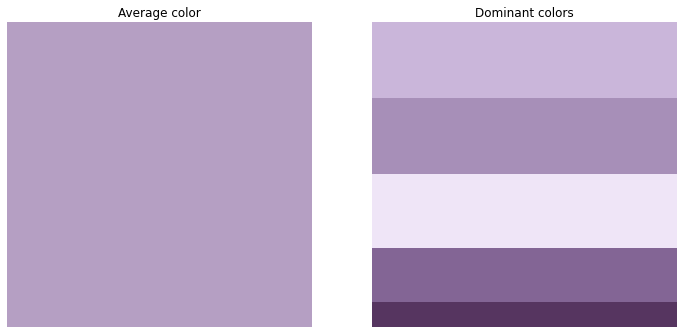

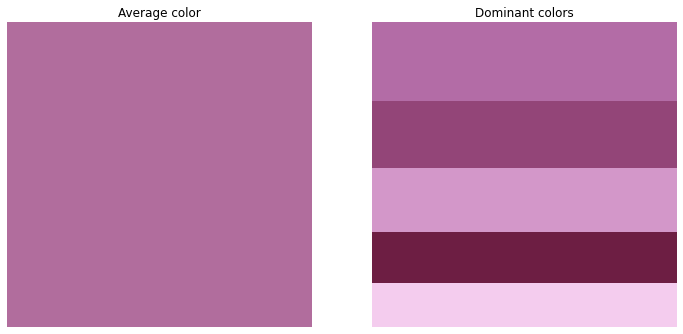

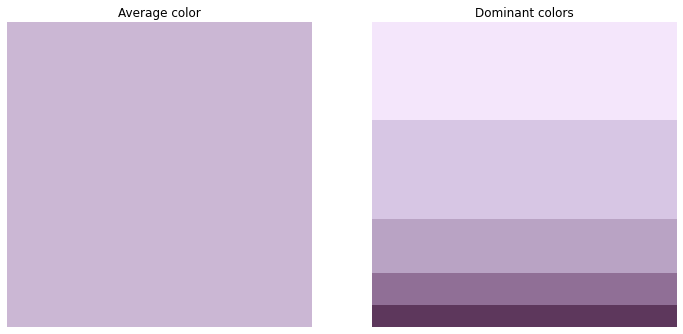

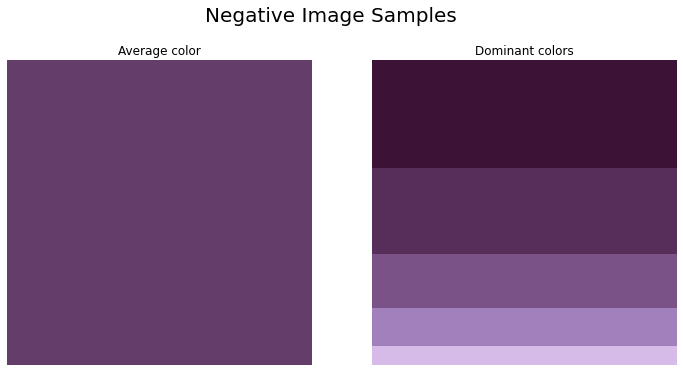

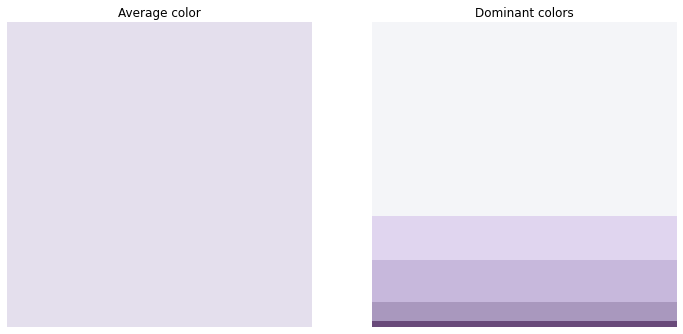

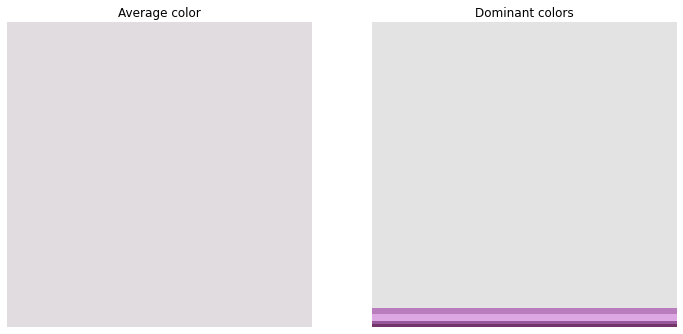

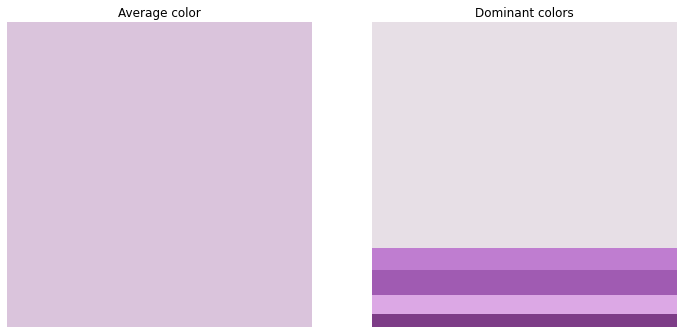

In [59]:
show_colors(positive_image_sample_array[0], 'pos', 'Positive Image Samples')
show_colors(positive_image_sample_array[1], 'pos', '')
show_colors(positive_image_sample_array[2], 'pos', '')
show_colors(positive_image_sample_array[len(positive_image_sample_array)-1], 'pos', '')
show_colors(negative_image_sample_array[0], 'neg', 'Negative Image Samples')
show_colors(negative_image_sample_array[1], 'neg', '')
show_colors(negative_image_sample_array[2], 'neg', '')
show_colors(negative_image_sample_array[len(negative_image_sample_array)-1], 'neg', '')

# Data Cleaning and Augmentation.

## Preprocessing

The Binary Class Mode in Keras preprocessing requires classes to be Strings.  This necessitates a translation from the stored data set which has classes stored as 0 and 1 format to represent negative and positive images, respectively.
Ref: https://keras.io/api/preprocessing/image/

The image ID in the label data set needs to also be adjusted to include the file extension since the mapping of ID will be used directly look up the image in the training and verification directories subsequent steps to set up the CNN.

In [60]:
# update labels since `class_mode='binary' requires classes to be strings.
label_data_df['label'] = np.where(label_data_df['label'] == 0, 'neg','pos')
# update image IDs to include the .tif file format for proper processing in
# subsequent steps.
label_data_df['id'] = label_data_df['id'] + '.tif'

## Image Preprocessing

Keras, the API for the popular open-source Google library for Machine Learning, Tensorflow, provides an Image Data Generator in the preprocessing image library which creates augmentations of a data set, to reduce overfitting.  

Overfitting can be noted by accuracy and solid metrics from training however less optimal results on testing against images not used in training.  

Since features could be found not representative of the desired features for training, augmenting the dataset to include variations on dataset images prior to model training can be adventageous to avoid overfitting.  The potential property settings for data autmentation I considered and experimented with this for this CNN are listed below.  Adding too much data augmentation to this model might prove to be adverse, and is a consideration in tuning the approach.  The best use for data augmentation is on a small dataset however the dataset is already quite robust.

## References

Definitions from docs, ref: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

Conceptual and applicative ref: https://towardsdatascience.com/image-augmentation-for-deep-learning-using-keras-and-histogram-equalization-9329f6ae5085

## model properties

featurewise_center: Boolean. Set input mean to 0 over the dataset, feature-wise.

samplewise_center: Boolean. Set each sample mean to 0.

featurewise_std_normalization: Boolean. Divide inputs by std of the dataset, feature-wise.

samplewise_std_normalization: Boolean. Divide each input by its std.

rotation_range:Int. Degree range for random rotations.,

width_shift_range:Float, 1-D array-like or int,

height_shift_range:Float, 1-D array-like or int,

brightness_range:Tuple or list of two floats. Range for picking a brightness shift value from.

shear_range:Shear angle in counter-clockwise direction in degrees,

zoom_range:Float or [lower, upper]. Range for random zoom

channel_shift_range: Float. Range for random channel shifts.

horizontal_flip: Boolean. Randomly flip inputs horizontally.,

fill_mode: One of {"constant", "nearest", "reflect" or "wrap"}. Default is 'nearest'                            

vertical_flip: Boolean. Randomly flip inputs vertically.,

brightness_range: Tuple or list of two floats. Range for picking a brightness shift value from,

validation_split: Float. Fraction of images reserved for validation (strictly between 0 and 1),

rescale: rescaling factor. normalise like: (x-x_min)/(x_max-x_min),

preprocessing_function: function that will be applied on each input.


In [ ]:

# train_datagen = ImageDataGenerator(
#         #rotation_range=15,
#         #width_shift_range=0.2,
#         #height_shift_range=0.2,
#         rescale=1./255,
#         #shear_range=0.2,
#         #zoom_range=0.2
#         #horizontal_flip=True,
#         #fill_mode='reflect',  | 'nearest'                             
#         #vertical_flip=True,
#         #brightness_range=[0.5, 1.5],
#         validation_split=0.15
# )

datagen_training = ImageDataGenerator(
        #normalize input x_scaled = (x-x_min)/(x_max-x_min)
        rescale=1./255, #keep
        validation_split=0.15, #keep
        #rotation_range=10,
        #shear_range=0.1, # do not keep.
        # width_shift_range=0.1,
        # height_shift_range=0.1,
        zoom_range=0.01, #keep
        horizontal_flip=True, #keep
        #vertical_flip=True, # do not keep.
        # preprocessing_function=myFunc, # maybe.  test over mult epoch.
)
  
datagen_testing = ImageDataGenerator(
    rescale=1./255,
)


# Data Preprocessing Using Image Data Generator Specifications

To Preprocess the data before it is fit to the model, it is necessary to combine the image generator specifications configured above with the the dataframe mapping the labels to images, and the directory information pointing to the images for training and testing.  The proper set of augmented images using the Keras api can be built using the method flow_from_dataframe also available in the preprocessing image library.  With this method we set the data up to be training in the model by specifying parameters including batch size, type of classifier, target size, and point the model fitting function to the actual images.  This Keras API method has an expectation or 'contract' with the way it expects to configure images, which fits perfectly with the setup that we have been provided.

flow_from_dataframe: is a special keras method to use data in a single folder that maps filenames of images with their class.  

## References:
https://keras.io/api/preprocessing/image/


In [ ]:
# set training data from train folder using labels dataframe
generator_training_flow = datagen_training.flow_from_dataframe(
                # point preprocessing method to the image/label mapping df
                dataframe=label_data_df,
                # point preprocessign method to the image folder
                directory=train_folder_res,
                # specify column for directory image lookup (class y given x)
                x_col = 'id',
                # specify column class for classification (x given class y)
                y_col = 'label',
                # name of this subset
                subset='training',
                # target size will be the output image size.
                target_size=dims,
                # batch size for each iteration within an epoch
                batch_size=64,
                # the type of classifier
                class_mode='binary'
                )

# set test data from test folder using labels dataframe.
# repeat above configuration so that testing specs match the training specs.
generator_testing_flow = datagen_testing.flow_from_dataframe(
                dataframe=label_data_df,
                directory=test_folder_res,
                x_col = 'id',
                y_col = 'label',
                subset='validation',
                target_size=dims,
                batch_size=64,
                shuffle=False,
                class_mode='binary'
                )


# Architecture

BIG TODO.

In [ ]:
# create the model
model = Sequential()

# add each layer
# Conv2D ref: https://keras.io/api/layers/convolution_layers/convolution2d/
# kernel_size = filter matrix size.
# activation function = ReLU.  Rectified Linear Activation.
# TODO: relu res.

# padding: one of "valid" or "same".  "valid" is no padding, "same" is even padding
# so that the output has the same height and width as the input.

# input shape maps to the output of the target_size defined in flow_from_dataframe. 

# CNNS are easier to interpret than other NNs.

# strides?

# depth of a filter must match the depth of the input or channel numbers.
# Convo layer is 2D to match dimensions of the input (2D because of width and height)

# Dropout: makes the composite of the model smaller and simpler by removing some
#. connections by setting weights to zero on some nodes.  Can be used after Conv layers.
# used as a regulariztion technique to reduce redundancy and reduce the potential for overfitting because the network
# becomes less sensitive to specific weights of neurons. value represents the probability with which any given node will be 
# dropped out.
#  Spacial Dropout would dropout the entire convolutional neural nets for future layers.

# MaxPooling2D picks one max value as representitive value.  
# pool_size: integer or tuple of 2 integers, window size over which to take the maximum
# ref: https://keras.io/api/layers/pooling_layers/max_pooling2d/
# maps to feature map with a 2x2 filter and stride of 2.  reduces the size of a feature map as if dividing each dimension by 2.
# results in a summarized version of the features found in the input.

# architecture:  VGGnet:  https://towardsdatascience.com/image-detection-from-scratch-in-keras-f314872006c9
model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = data_shape))
model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3))

model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3))

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3))

model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
model.add(Dropout(0.3))

# complete with a fully connected layer.
# Flatten connects convolution and dense layers.
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
# classification layer for output.
# Dense is a standard layer type used for an output layer.
# sigmoid activation is used for classification.  returns a value between 0 and 1.
# e^x/(e^x + 1)
# 1: a node which is the possible outcome.
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

In [ ]:
# alt architecture 1.  VGGnet.
# create the model
model = Sequential()

# architecture:  VGGnet:  https://towardsdatascience.com/image-detection-from-scratch-in-keras-f314872006c9
model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = data_shape))

model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

# complete with a fully connected layer.
# Flatten connects convolution and dense layers.
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
# classification layer for output.
# Dense is a standard layer type used for an output layer.
# sigmoid activation is used for classification.  returns a value between 0 and 1.
# e^x/(e^x + 1)
# 1: a node which is the possible outcome.
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

# Code and Calculations for Metric Analysis.

Decisions on the metrics to log in each epoch cycle will be specified in the subsequent model compilation step.  The metrics for loss and accuracy are provided in Keras, however these additional metrics on recall, precision, and F-1 value give us further insight into how the model is performing.

Logging these metrics can be adventageous in determining appropriate architecture, tuning params, and making decisions on how to best preprocess data, given multiple trial runs with various configurations of these subcomponents in the CNN.

TODO: determine optimal values for these for analysis.

## Recall:  Calculates positive predictions out of all positive samples in the data
recall = true positives / (true positives + false negatives)

## Precision:  Calculates the number of positive samples that are actually positive.
precision = true positives / (true positives + false positives)


## F-1:  A single score that balances precision and recall values
F1 = (2 * precision * recall) / (precision + recall)


Reference: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

In [ ]:
def recall_m(y_true, y_pred):
    # true positives are found by multiplying the number true times the percent predicted.
    # K.clip clips the multiplication of items predicted and actually existing to between 0 and 1.
    # K.round (TODO)
    # K.sum (TODO)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [ ]:
# ex. model.add(Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(32, 32, 3)))

# Compile and Fit the Model

optimizer controls the learning rate.  'adam' is an optimizer makes
adjustments to the learning rate during training.  smaller learning
rate may be more accurate at the cost of more time.
https://faroit.com/keras-docs/0.2.0/optimizers/

loss: binary_crossentropy.  
   predicts loss between true lavels and predicted labels.
.   lower score reflects accurate performance.
https://keras.io/api/losses/

metrics: logs whichever metrics desired as a printout during training.
accuracy:  This frequency is ultimately returned as binary accuracy 
ref: https://keras.io/api/metrics/accuracy_metrics/#binaryaccuracy-class

epoch:  Entire db is passed through the model.  # is relevant to diversity of data.
batches:  Number of iterations of an epoch.  
step size:  Total number in data set / batch size.



# Original Images

In [ ]:
# TODO (add metrics back in for precision, recall, f1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# TODO (find additional reference for this setup.)
STEP_SIZE_TRAINING=generator_training_flow.n//generator_training_flow.batch_size
# Total number of images in the data set / batch size 
# (batch size is set in preprocessing api above).
STEP_SIZE_TESTING=generator_testing_flow.n//generator_testing_flow.batch_size

model.fit_generator(
                generator_training_flow,
                steps_per_epoch=STEP_SIZE_TRAINING,
                epochs=20,
                validation_data=generator_testing_flow,
                validation_steps=STEP_SIZE_TESTING)

ref on, 'fit or fit_generator':  https://www.geeksforgeeks.org/keras-fit-and-keras-fit_generator/

# Cropped Images

## Metric Analysis on Performance

Big TODO

In [ ]:
# max: 0.9179 on non cropped images.
# .86/ 20 epoch with cropped images and standard.
# .599/ 20 cropped and nonstandard.

In [ ]:
# metrics:  https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226
# accuracy, precision, recall.
# f1, log loss (specific for binary classification), auc

# howto?  calc myself or use classificationReport from scikit
# https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
# https://keras.io/api/metrics/accuracy_metrics/#binaryaccuracy-class